# Quick and dirty visualization of the COVID-19 pandemic & a very unscientific logistic regression

In [1]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Get and process WHO data

Note that we remove China from all considerations, also its contribution to the worldwide data. We do so, because we think that there are multiple reasons it improves our analysis of the data.

In [2]:
url = "http://cowid.netlify.com/data/full_data.csv"
urllib.request.urlretrieve(url, "full_data.csv")
raw_df = pd.read_csv("full_data.csv").sort_values("date", ascending=True)

In [3]:
def get_locational_data(location, drop_location=True, replace_nan=True, reindex=True):
    df_local = raw_df[raw_df['location'] == location].set_index("date")
    if drop_location:
        df_local = df_local.drop(['location'], axis=1)
    if replace_nan:
        df_local = df_local.fillna(0)

    df_local.index = pd.to_datetime(df_local.index, format='%Y-%m-%d')
    if reindex and location != "World" and location != "China":
        earliest_date = get_locational_data("World").index.min()
        newest_date = df_local.index.max()
        idx = pd.date_range(earliest_date, newest_date)
        df_local = df_local.reindex(idx, fill_value=0)

    if location == "World":
        return df_local - get_locational_data("China")
    return df_local

earliest_date = get_locational_data("World").index.min()
newest_date = get_locational_data("World").index.max()
print(f"Our first data point outside China comes from the {earliest_date.date()} and our newest from the {newest_date.date()}.")

Our first data point outside China comes from the 2020-01-21 and our newest from the 2020-03-17.


In [4]:
def get_statistically_informative_locations(min_number_of_total_cases=4000):
    locations = list(raw_df.location.unique())

    informative_locations = []
    for location in locations:
        df_local = get_locational_data(location)

        if location == "China":
            continue
        if df_local.total_cases.max() < min_number_of_total_cases:
            continue

        informative_locations += [location]

    return informative_locations

informative_locations = get_statistically_informative_locations()
print(f"We will focus on the {len(informative_locations)} locations:", ", ".join(informative_locations))

We will focus on the 7 locations: South Korea, World, France, Germany, Italy, Spain, Iran


## Plot ``informative_locations`` to get an overview of the development.

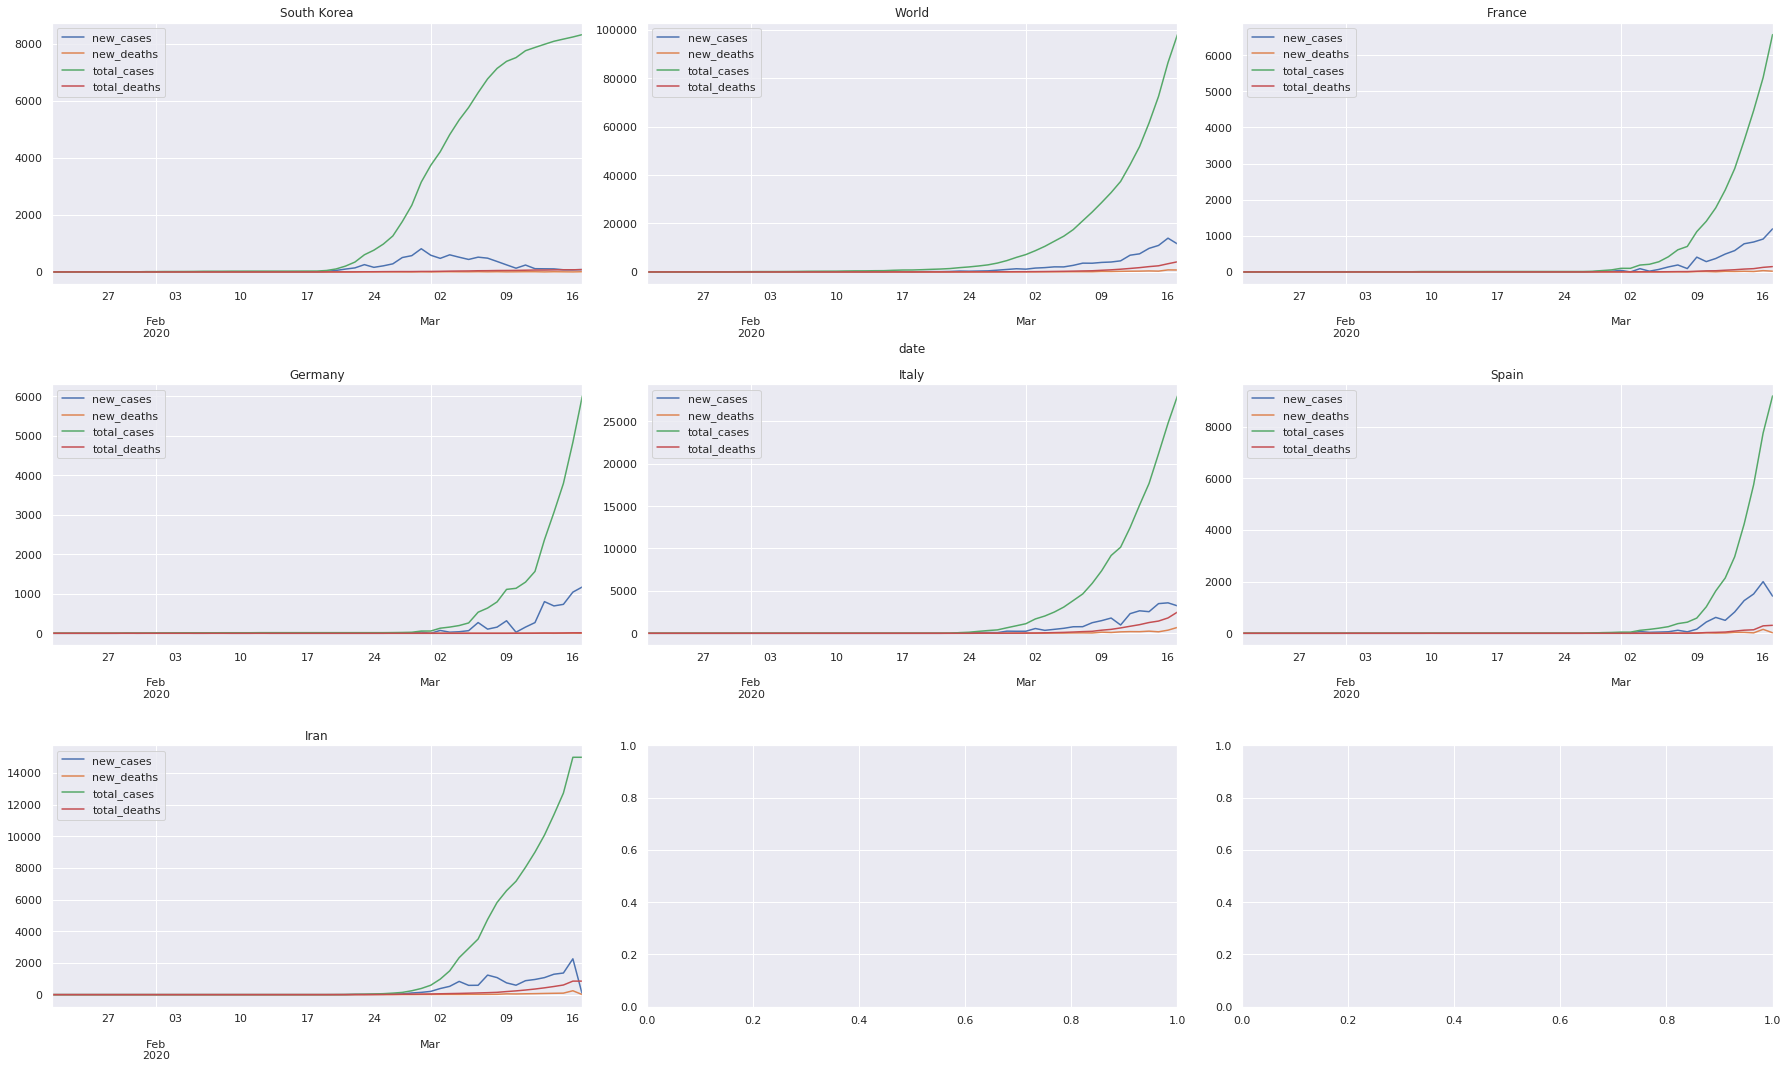

In [5]:
def plot_informative_locations(log_plot=False):
    m = int(np.ceil(np.sqrt(len(informative_locations))))
    n = int(np.ceil(len(informative_locations) / m))
    fig, axes = plt.subplots(m,n, figsize = (25, 15))

    for i, location in enumerate(informative_locations):
        df_local = get_locational_data(location)
        ax = axes[i//n, i%n]
        ax.set_title(location)
        df_local.plot(ax=ax, logy=log_plot)

    fig.tight_layout()
    plt.show()

plot_informative_locations(log_plot=False)

### Log-plot ``informative_locations``

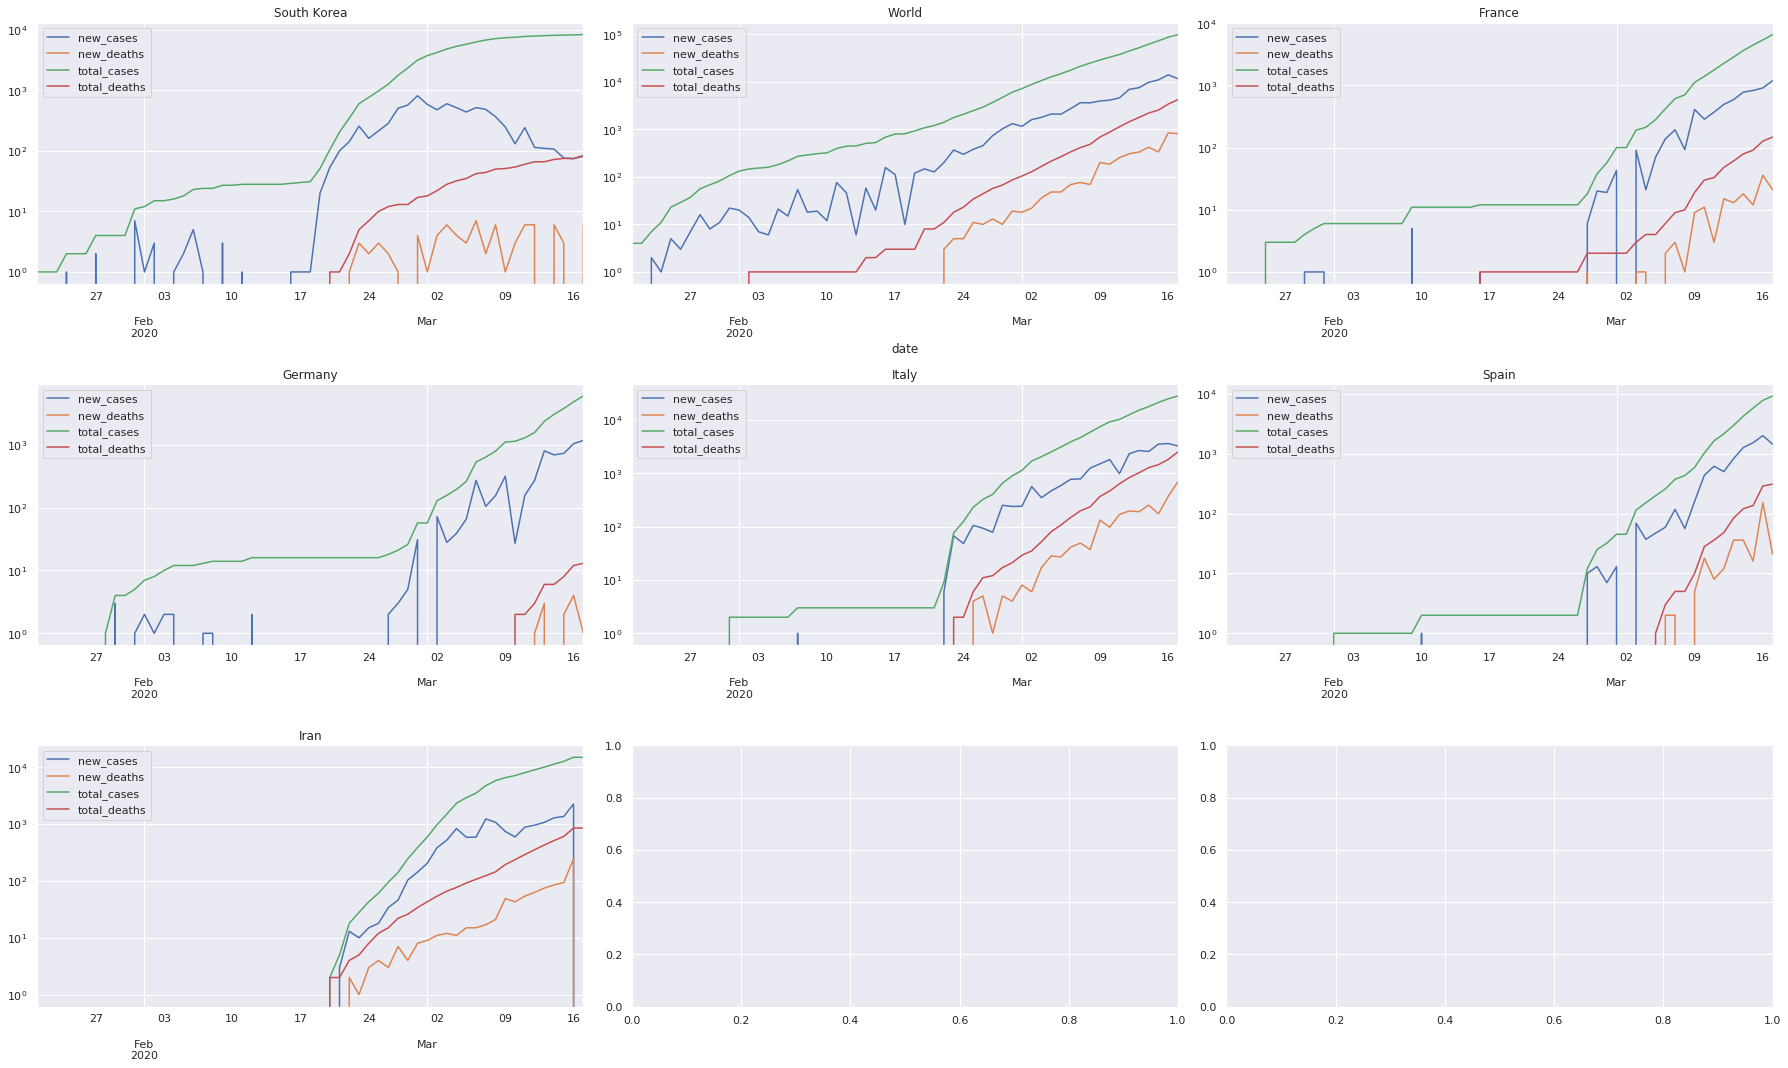

In [6]:
plot_informative_locations(log_plot=True)

### Percentage of ``total_deaths`` over ``total_cases``

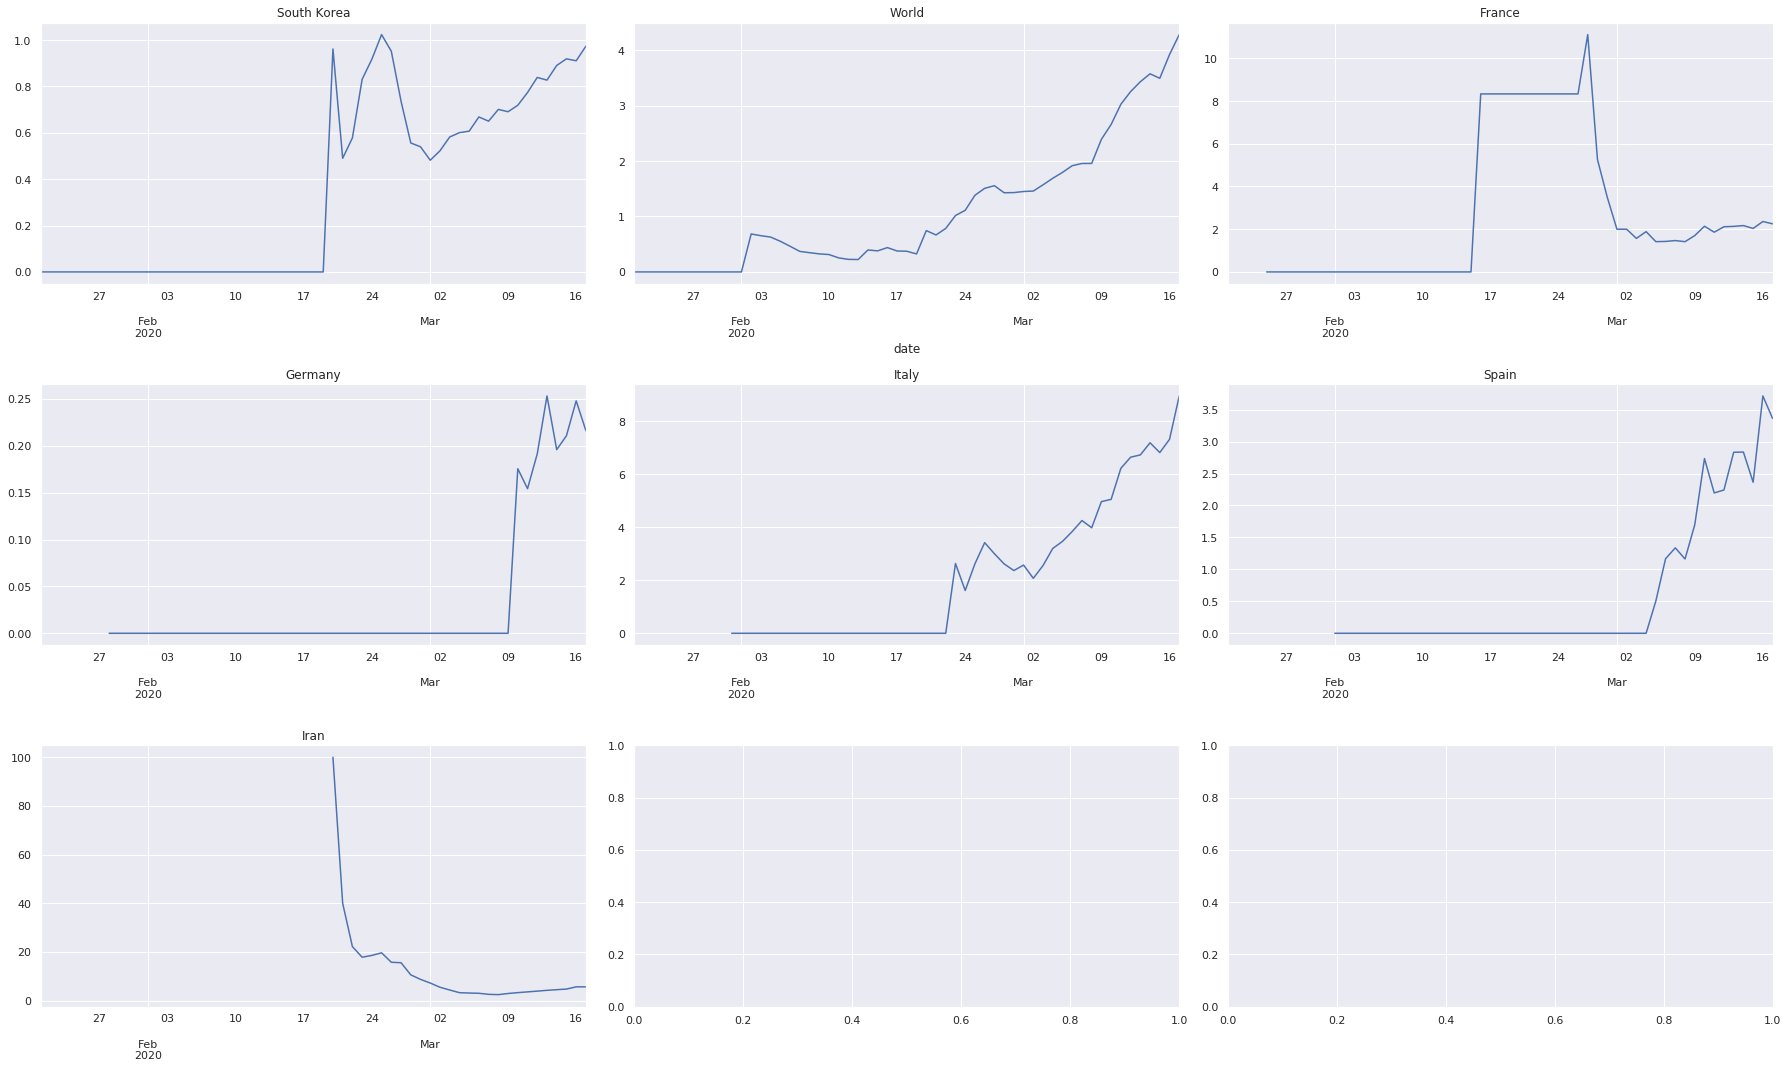

In [7]:
m = int(np.ceil(np.sqrt(len(informative_locations))))
n = int(np.ceil(len(informative_locations) / m))
fig, axes = plt.subplots(m,n, figsize = (25, 15))

for i, location in enumerate(informative_locations):
    df_local = get_locational_data(location)
    df_local = 100 * df_local.total_deaths / df_local.total_cases
    ax = axes[i//n, i%n]
    ax.set_title(location)
    df_local.plot(ax=ax)

fig.tight_layout()
plt.show()

## Code for a regression analysis based on a ``logistic_curve``

In [8]:
def logistic_curve(curves_maximum_value, growth_rate, midpoint, x):
    """
    Logistic curve, see https://en.wikipedia.org/wiki/Logistic_function
    """
    return curves_maximum_value / (1 + np.exp(-growth_rate*(x-midpoint)))

def δlogistic_curve(curves_maximum_value, growth_rate, midpoint, x):
    """
    Derivative of the logistic curve, for a more stable fit.
    """
    tmp = growth_rate/2 * (x-midpoint)
    return growth_rate*curves_maximum_value / (np.exp(-tmp) + np.exp(tmp))**2

In [9]:
def get_logistic_curve_loss(curves_maximum_value, growth_rate, midpoint, xs, ys):
    ys_predict = logistic_curve(curves_maximum_value, growth_rate, midpoint, xs)
    loss = np.sum((ys - ys_predict)**2)
    return loss

def get_δlogistic_curve_loss(curves_maximum_value, growth_rate, midpoint, xs, δys):
    δys_predict = δlogistic_curve(curves_maximum_value, growth_rate, midpoint, xs)
    loss = np.sum((δys - δys_predict)**2)
    return loss

In [10]:
def get_fit(df_local, λ=5):
    """
    Get fit via a terrible grid search... but hey, 3 dimensions.
    """
    xs = np.arange(len(df_local))
    ys = df_local['total_cases'].values
    δys = df_local['new_cases'].values

    min_loss = np.inf
    best_curves_maximum_value, best_growth_rate, best_midpoint = None, None, None

    for curves_maximum_value in np.logspace(np.log10(np.max(ys)), 10, 100):
        for growth_rate in np.linspace(0.1, .6, 100):
            for midpoint in np.linspace(30, 130, 130-30+1):
                loss_y = get_logistic_curve_loss(curves_maximum_value, growth_rate, midpoint, xs, ys)
                loss_δy = get_δlogistic_curve_loss(curves_maximum_value, growth_rate, midpoint, xs, δys)
                loss = loss_y + λ*loss_δy
                if min_loss > loss:
                    min_loss = loss
                    best_curves_maximum_value, best_growth_rate, best_midpoint = curves_maximum_value, growth_rate, midpoint
    return best_curves_maximum_value, best_growth_rate, best_midpoint

In [11]:
calendar = pd.date_range('2020-01-21', '2021-01-21').date

In [12]:
def plot_prediction(location, x_ticks_subsampling=1):
    df_local = get_locational_data(location)
    best_curves_maximum_value, best_growth_rate, best_midpoint = get_fit(df_local)
    info_str = f"Predictions for {location}:\n" \
             + f"Final number of infected: {int(round(best_curves_maximum_value))}\n" \
             + f"with a maximal number of newly infected {int(round(best_curves_maximum_value*best_growth_rate))}\n" \
             + f"at the {calendar[int(round(best_midpoint))]}."

    xs = np.arange(len(df_local))
    ys = df_local['total_cases'].values
    δys = df_local['new_cases'].values
    ys_predict = logistic_curve(best_curves_maximum_value, best_growth_rate, best_midpoint, xs)
    δys_predict = δlogistic_curve(best_curves_maximum_value, best_growth_rate, best_midpoint, xs)

    print(best_curves_maximum_value, best_growth_rate, best_midpoint)
    plt.title(info_str)
    plt.plot(xs, ys, c='b')
    plt.plot(xs, δys, c='r')
    plt.plot(xs, ys_predict, c='b', linestyle='dashed')
    plt.plot(xs, δys_predict, c='r', linestyle='dashed')
    xs_ticks = xs[::x_ticks_subsampling]
    plt.xticks(xs_ticks, calendar[xs_ticks], rotation="vertical")
    fig = plt.gcf()
    fig.set_size_inches(20,2)
    plt.show()

## Do and plot the regression analysis  for ``informative_locations``.

8320.000000000002 0.3070707070707071 41.0


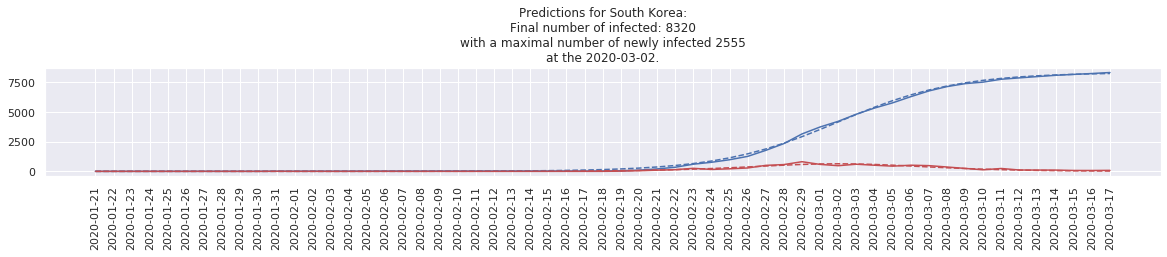

631989.7431714399 0.17070707070707072 66.0


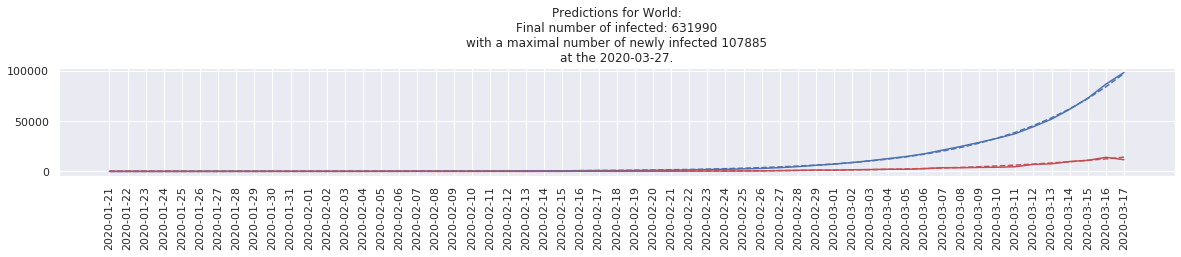

20765.30375035298 0.26161616161616164 59.0


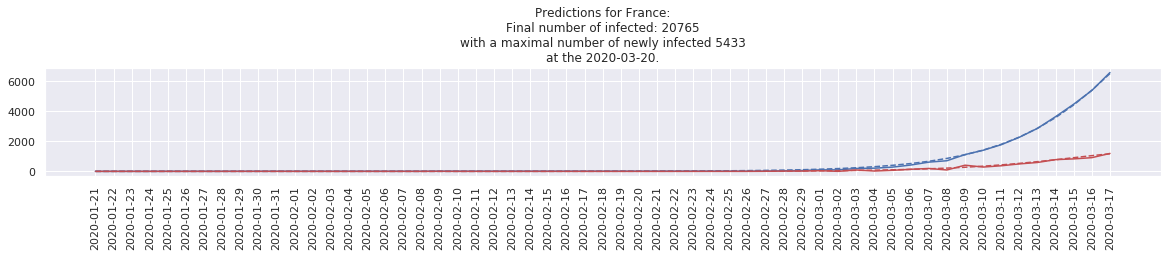

39438.05338579107 0.2515151515151515 63.0


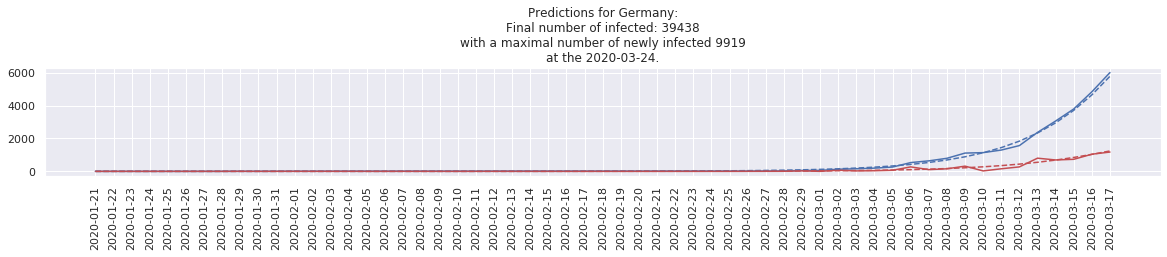

69102.67218353407 0.21616161616161617 58.0


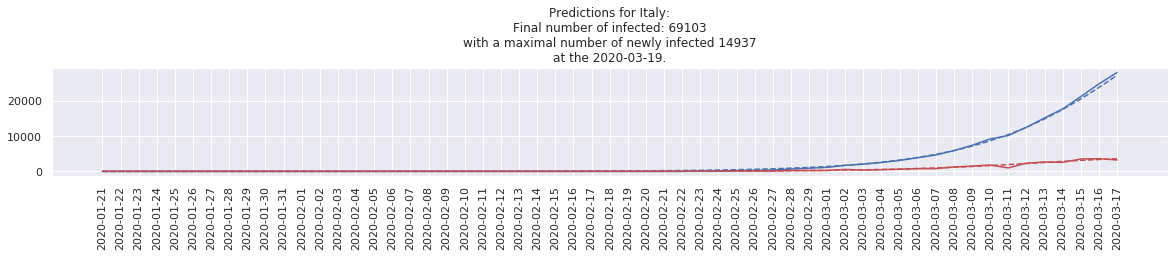

18545.708721566625 0.397979797979798 56.0


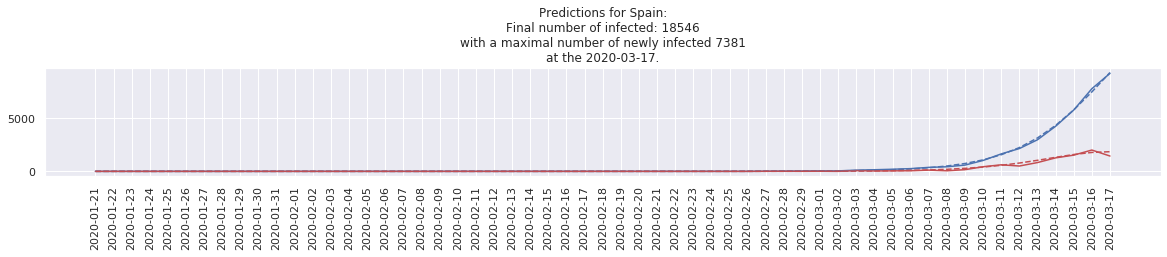

19655.79400127056 0.2515151515151515 51.0


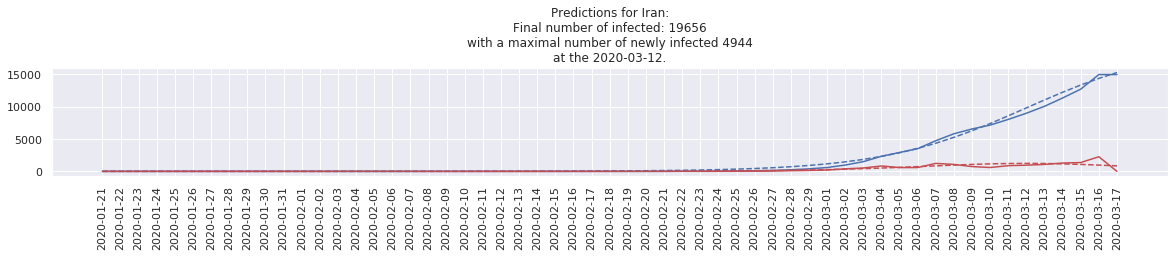

In [13]:
for location in informative_locations:
    plot_prediction(location)

# Note that I do not trust those predictions myself!